In [ ]:
from CB_02704 import *
from functions import *
import numpy as np

In [2]:
# read the admixed population data
pop_admixed_raw = np.load('data/simulated_genomes.npy')
# limit to chr 1
pop_admixed_raw = pop_admixed_raw[:55983, :]
# convert to masked array
mask = (pop_admixed_raw == 9)
pop_admixed = np.ma.masked_array(pop_admixed_raw, mask = mask)

In [3]:
pop_gen1 = read_geno_pop_chr('YRI', 1)
pop_gen2 = read_geno_pop_chr('CEU', 1)
pop_gen3 = read_geno_pop_chr('JPT', 1)
pop_gen4 = read_geno_pop_chr('ASW', 1)

In [4]:
# make the list storing information of which population each individual belongs to
population_list = ['YRI']*pop_gen1.shape[1] + ['CEU']*pop_gen2.shape[1] + ['JPT']*pop_gen3.shape[1] + ['ASW']*pop_gen4.shape[1] + ['Simulated']*pop_admixed.shape[1]

In [29]:
# make the list storing information of which population each individual belongs to
population_list_num = [0]*pop_gen1.shape[1] + [1]*pop_gen2.shape[1] + [2]*pop_gen3.shape[1] + [3]*pop_gen4.shape[1] + [4]*pop_admixed.shape[1]

In [5]:
# horizontally stack the three populations
pop_gen = np.ma.hstack([pop_gen1, pop_gen2, pop_gen3, pop_gen4, pop_admixed])

### STRUCTURE data modification

In [60]:
# the structure input data creation
structure_input_data_half_rows = pop_gen.data.T.astype(int)
# make an empty np.array with double rows with all zeros initially
structure_input_data = np.zeros((structure_input_data_half_rows.shape[0]*2, structure_input_data_half_rows.shape[1]+2)) # the 2 extra cols are to store the information for the individial index and population from which that ind comes

In [61]:
structure_input_data.shape

(1020, 55985)

In [62]:
# now loop and fill up the array row by row
for i in range(structure_input_data.shape[0]):
    # for the first two cols of each row, we add appropriate ind index and population
    structure_input_data[i,0] = int(i/2)
    structure_input_data[i,1] = population_list_num[int(i/2)]

    # giving the contribution of genotype to only the first chr here. Corner case if the value is 2, as one chr cannot contribute 2 counts of an allele
    if i%2 == 0: # even indexed row
        structure_input_data[i, 2:] = structure_input_data_half_rows[int(i/2),:]
    else:  # odd indexed row
        pass

In [63]:
# now in the structure_input_data array, each time there is a 2, make that entry a 1 and the one directly below it
# also 1
for row in range(structure_input_data.shape[0]):
    for col in range(2,structure_input_data.shape[1]):
        if structure_input_data[row, col] == 2:
            # make that and the entry below it as 1
            structure_input_data[row, col] = 1
            structure_input_data[row+1, col] = 1

In [64]:
df1 = pd.DataFrame(structure_input_data.astype(int))
df1

,0,1,2,3,4,5,6,7,8,9,...,55975,55976,55977,55978,55979,55980,55981,55982,55983,55984
0,0,0,0,1,1,1,1,1,1,1,...,0,0,0,0,1,1,1,0,1,1
1,0,0,0,0,0,0,1,1,0,0,...,0,0,0,0,0,1,1,0,1,0
2,1,0,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
3,1,0,0,0,0,1,1,1,0,0,...,0,0,0,1,1,1,1,0,1,1
4,2,0,0,0,0,1,1,1,1,1,...,0,0,0,0,1,1,1,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1015,507,4,0,0,0,0,1,0,0,0,...,1,1,1,1,0,0,0,0,0,0
1016,508,4,1,1,1,1,1,1,1,1,...,1,1,1,1,1,0,0,1,0,0
1017,508,4,0,0,0,0,1,0,1,1,...,1,1,1,1,1,0,0,1,0,0
1018,509,4,0,1,1,1,1,1,0,1,...,1,1,1,1,1,1,1,0,1,1


In [65]:
df1.iloc[:,:3000].to_csv('STRUCTURE/3k_snps_data', sep='\t', index=False)

### PCA on the data

In [33]:
pop_gen1.shape[1], pop_gen2.shape[1], pop_gen3.shape[1], pop_gen4.shape[1], pop_admixed.shape[1]

(113, 112, 86, 49, 150)

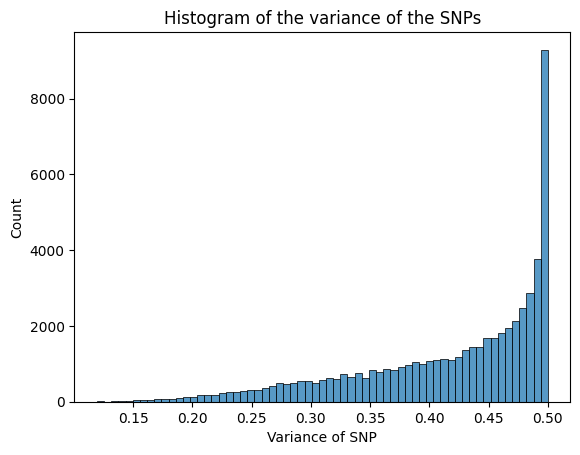

In [34]:
PlotVarianceOfFeatures(pop_gen, title = 'Histogram of the variance of the SNPs')

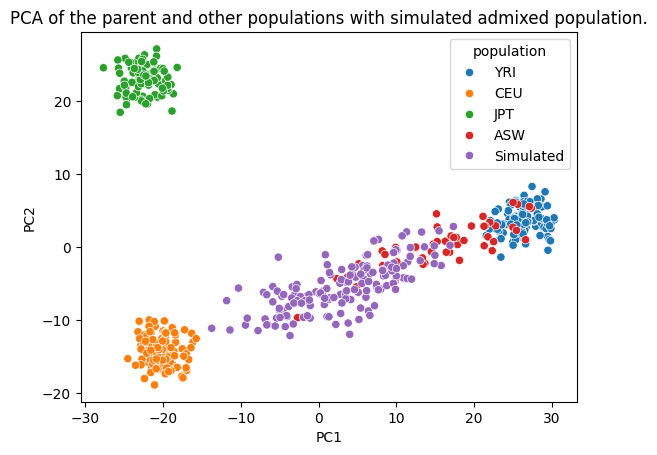

In [35]:
x_values, y_values, eigenvalues, cov = PCA(pop_gen, top_x_features=3000)
PlotPCA(x_values, y_values, population_list, title = "PCA of the parent and other populations with simulated admixed population.")

### admixture-LD

In [16]:
# We need to bin the SNPs from first chr and then compute correlation between snps from different bins
# (we have the function set up to compute the LD (r2 value) between any pair of SNPs in any population)
snp_data = read_snp_pop('YRI')
snp_data = snp_data[snp_data['chromosome'] == 1]
snp_data

,chromosome,morgans,position,ref,alt
rs3131972,1,0.0,742584,G,A
rs3131969,1,0.0,744045,G,A
rs3131967,1,0.0,744197,C,T
rs1048488,1,0.0,750775,T,C
rs12562034,1,0.0,758311,G,A
...,...,...,...,...,...
rs12027301,1,0.0,247093448,C,T
rs9727917,1,0.0,247093596,G,A
rs6695844,1,0.0,247095331,A,G
rs12135449,1,0.0,247116109,C,T


In [ ]:
# we will just make bins including snps at distance of 10kb, and do binning till 1000 of such bins.
# Hence, we will cover 10mb of chr1 length

# parameters for binning
num_bins = 150
bin_length = 10000

# lets create an array storing the indices at which the bins split
bin_split_indices = []
bin_split_indices.append(0)
itr = 1
while len(bin_split_indices) < num_bins + 1:
    # the genomic position of current row we are looking at in the snp_data
    curr_genomic_position = snp_data['position'][itr]
    # the genomic position of where the active bin had started (we need to make new when dist > bin_length)
    bin_start_genomic_position = snp_data['position'][bin_split_indices[-1]]
    if curr_genomic_position > bin_start_genomic_position + bin_length: # more distant than bin_length from start
        # start new bin at this point. This snp should be in the next bin
        bin_split_indices.append(itr)
    itr += 1

In [96]:
# now loop through all possible bin_gaps (how much distant bins we are talking about) and get all the 
# bin pairs for a given bin_gap and compute avg correlation between pair of set of snps for that bin_gap
# and store in a dict

# first make the dicts storing gap-average correlation for each pop
pop_admixed_correlation_dict = {}
pop_gen1_correlation_dict = {}
pop_gen2_correlation_dict = {}
pop_gen3_correlation_dict = {}
pop_gen4_correlation_dict = {}

# first loop a bin gap which will determine how distant the pair of bins we are looking at, are
for bin_gap in range(0, num_bins): # bin_gap 0 means the two bins will be same
    # make a variable which will store the correlation values for all bin-pairs at current gap (specific to a pop)
    correlations_for_current_gap_admixed = []
    correlations_for_current_gap_gen1 = []
    correlations_for_current_gap_gen2 = []
    correlations_for_current_gap_gen3 = []
    correlations_for_current_gap_gen4 = []

    # now, make a loop to get the first bin and accodingly we will get which will be the second bin
    for bin1_index in range(0, num_bins-bin_gap):

        # now make a variable storing bin2_index value
        bin2_index = bin1_index+bin_gap

        # now we can make the lists (arrays actually) storing the indices of snps in each bin
        list1 = np.arange(start = bin_split_indices[bin1_index], stop = bin_split_indices[bin1_index + 1])
        list2 = np.arange(start = bin_split_indices[bin2_index], stop = bin_split_indices[bin2_index + 1])

        # now we can use the 2 lists of snp_indices to compute the avg correlation between them (inter-list)
        correlations_for_current_gap_admixed.append(AvgCorrelationBetweenPairOfSetOfSNPs(list1, list2, pop_admixed))
        correlations_for_current_gap_gen1.append(AvgCorrelationBetweenPairOfSetOfSNPs(list1, list2, pop_gen1))
        correlations_for_current_gap_gen2.append(AvgCorrelationBetweenPairOfSetOfSNPs(list1, list2, pop_gen2))
        correlations_for_current_gap_gen3.append(AvgCorrelationBetweenPairOfSetOfSNPs(list1, list2, pop_gen3))
        correlations_for_current_gap_gen4.append(AvgCorrelationBetweenPairOfSetOfSNPs(list1, list2, pop_gen4))

    # now, take the average of correlations we obtained for the given bin_gap
    pop_admixed_correlation_dict[bin_gap] = correlations_for_current_gap_admixed
    pop_gen1_correlation_dict[bin_gap] = correlations_for_current_gap_gen1
    pop_gen2_correlation_dict[bin_gap] = correlations_for_current_gap_gen2
    pop_gen3_correlation_dict[bin_gap] = correlations_for_current_gap_gen3
    pop_gen4_correlation_dict[bin_gap] = correlations_for_current_gap_gen4

    # checking progress
    # print(f'bin gap {bin_gap} processed out of total {num_bins}')

In [105]:
# now we can use the DataframeFromDict function to make a combined df of correlation values for snps at different 
# distances for the different population datas
df = pd.DataFrame()
df = pd.concat([df, DataframeFromDict(pop_admixed_correlation_dict, 'admixed')])
df = pd.concat([df, DataframeFromDict(pop_gen1_correlation_dict, 'YRI')])
df = pd.concat([df, DataframeFromDict(pop_gen2_correlation_dict, 'CEU')])
df = pd.concat([df, DataframeFromDict(pop_gen3_correlation_dict, 'JPT')])
df = pd.concat([df, DataframeFromDict(pop_gen4_correlation_dict, 'ASW')])
df['genomic distance'] = df['distance']*bin_length/1000
df

,distance,correlation_values,label,genomic distance
0,0,0.859830,admixed,0.0
1,0,1.000000,admixed,0.0
2,0,1.000000,admixed,0.0
3,0,0.579127,admixed,0.0
4,0,0.649269,admixed,0.0
...,...,...,...,...
11320,147,0.004004,ASW,1470.0
11321,147,0.026061,ASW,1470.0
11322,148,0.026333,ASW,1480.0
11323,148,0.029832,ASW,1480.0


In [107]:
# subset df to only those rows which have distance <= 100
df = df[df['distance'] <= 100]
df

,distance,correlation_values,label,genomic distance
0,0,0.859830,admixed,0.0
1,0,1.000000,admixed,0.0
2,0,1.000000,admixed,0.0
3,0,0.579127,admixed,0.0
4,0,0.649269,admixed,0.0
...,...,...,...,...
10095,100,0.063438,ASW,1000.0
10096,100,0.000000,ASW,1000.0
10097,100,0.043646,ASW,1000.0
10098,100,0.011699,ASW,1000.0


Text(0.5, 1.0, 'Admixture-LD demonstration: average correlation values between SNPs at a distance')

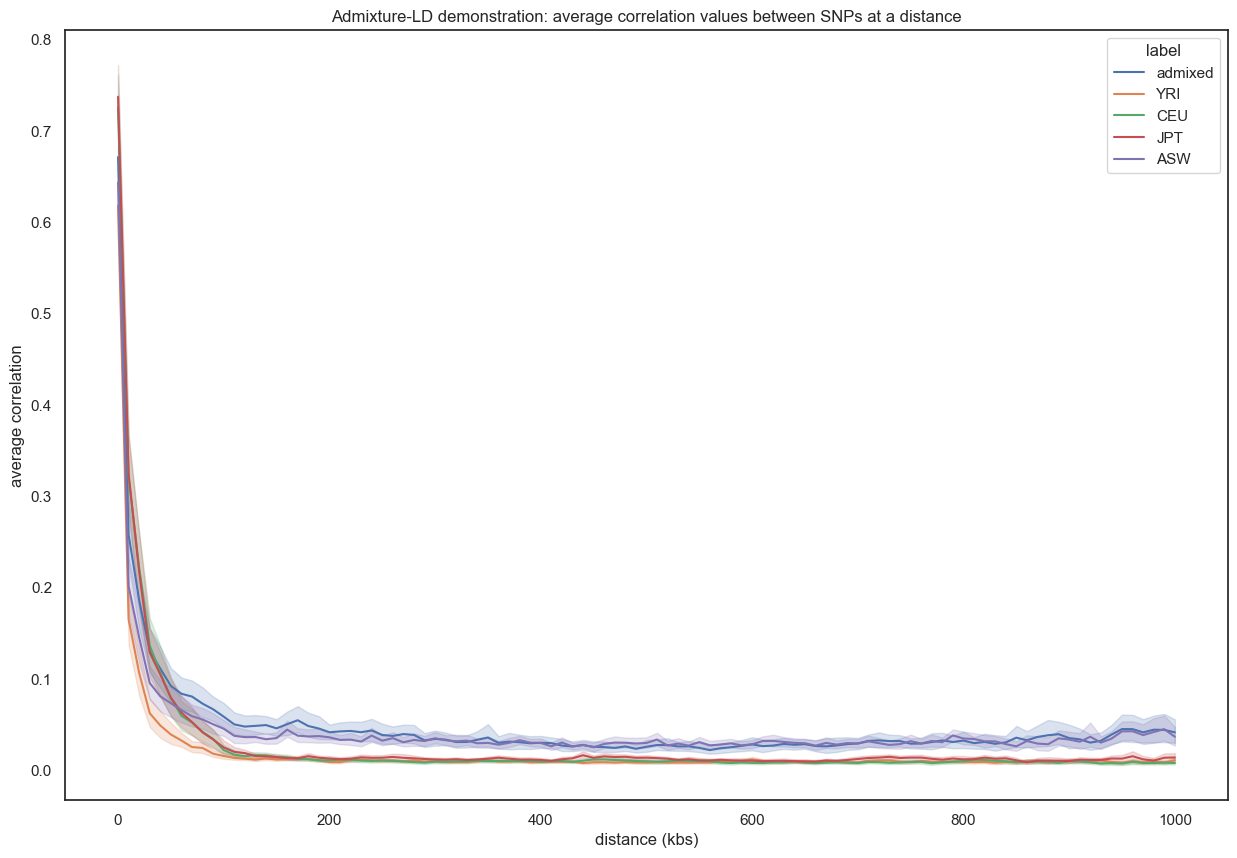

In [111]:
# now we just have to plot the lineplot
sns.set_theme(rc={'figure.figsize': (15,10)}, style = 'white')
sns.lineplot(df, x = 'genomic distance', y = 'correlation_values', hue = 'label', errorbar= 'ci')
plt.xlabel('distance (kbs)')
plt.ylabel('average correlation')
# plt.yscale('log')
plt.title('Admixture-LD demonstration: average correlation values between SNPs at a distance')